# Predict energy demand in France

In [1]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.stats import pearsonr, randint, uniform
from scipy.spatial.distance import correlation

import matplotlib.pyplot as plt

### Note:

You will need to change the kernel to ml_env to use `mlxtend`

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

In [5]:
region = "FR"

### Demand

In [6]:
def rm_weekend(da):
    """
    Set weekend days to NaN
    """
    return da.where(da.time.dt.dayofweek < 5, drop=False)

In [7]:
def rm_month(da, month):
    """
    Set a particular month to NaN
    """
    return da.where(da.time.dt.month != month, drop=False)

In [8]:
def rm_xmas(da):
    """
    Set 21/12 through 06/01 to NaN
    """
    da_ = da.where(
        da.where(
            (da.time.dt.month == 12) & 
            (da.time.dt.day > 20),
            drop=False
        ).isnull()
    )
    da_ = da_.where(
        da_.where(
            (da_.time.dt.month == 1) & 
            (da_.time.dt.day < 7),
            drop=False
        ).isnull()
    )
    return da_

In [9]:
def rm_nan(x):
    """
    Remove NaNs from array
    """
    return x[~np.isnan(x)]

In [10]:
demand = pd.read_csv(
    "/g/data/w42/dr6273/work/data/ENTSOE/ENTSOE_daily_demand_2006-2018.csv",
    index_col=0,
    parse_dates=True
)

In [11]:
demand = demand[demand["Country"] == region]["Power (MWh/day)"]

In [12]:
dem_da = xr.DataArray(
    demand.squeeze(),
    dims=["time"],
    coords={"time": demand.index.values}
)

In [13]:
dem_da = dem_da.expand_dims({"region": [region]})

In [14]:
dem_da = fn.detrend_dim(dem_da, "time") + dem_da.mean("time")

In [15]:
dem_da = rm_weekend(dem_da)
dem_da = rm_xmas(dem_da)
dem_da = rm_month(dem_da, 8)

In [16]:
dem_da = dem_da.dropna("time")

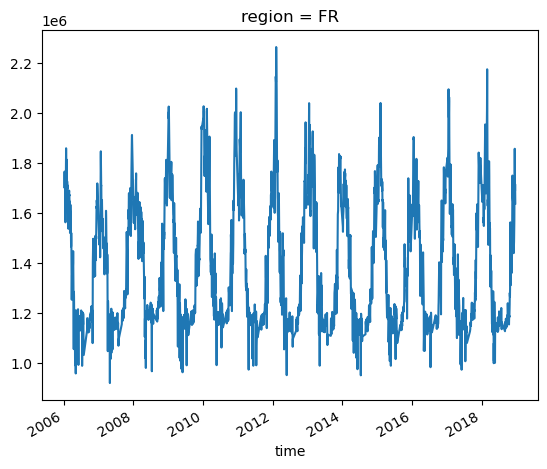

In [17]:
dem_da.plot()

### Predictors

In [18]:
files = fn.get_predictor_files("EU", "pop_dens_mask")

In [19]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override")

In [20]:
pred_ds = pred_ds.sel(region=region).expand_dims({"region": [region]}).compute()

In [21]:
pred_ds.data_vars

Data variables:
    hdd       (region, time) float64 8.329 9.109 10.6 ... 6.406 5.708 2.232
    t2min     (region, time) float64 nan 275.9 274.8 273.6 ... 278.8 278.0 283.4
    q         (region, time) float64 5.187 4.848 4.423 ... 6.038 6.935 7.073
    rh        (region, time) float64 83.59 81.16 82.06 ... 84.61 92.13 75.65
    msdwswrf  (region, time) float64 53.54 40.97 57.5 ... 34.07 17.45 45.65
    t2m       (region, time) float64 279.9 279.1 277.6 ... 281.7 282.4 285.9
    mtpr      (region, time) float64 9.475e-06 8.388e-05 ... 7.003e-05 1.753e-05
    t2max     (region, time) float64 nan 281.7 279.4 278.6 ... 283.4 285.6 287.6
    w10       (region, time) float64 3.19 5.238 3.507 ... 4.716 5.345 6.574
    cdd       (region, time) float64 0.0234 0.0234 0.02339 ... -0.0234 -0.0234

In [22]:
pred_ds = rm_weekend(pred_ds)
pred_ds = rm_xmas(pred_ds)
pred_ds = rm_month(pred_ds, 8)
pred_ds = pred_ds.dropna("time")

## Prepare data

In [23]:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
# time_cols = ["is_weekend", "is_transition"]
# time_cols = ["is_weekend"]
time_cols = []

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [24]:
# region_dfs["NEM"].head()

In [25]:
region_dfs[region]

,demand,hdd,t2min,q,rh,msdwswrf,t2m,mtpr,t2max,w10,cdd
2006-01-09,1.705217e+06,12.830156,272.657808,4.025527,88.573776,47.682237,275.296031,2.371277e-05,279.068155,1.637494,-0.010986
2006-01-10,1.758981e+06,13.984140,271.595228,3.784367,90.981190,48.892031,274.142046,8.657164e-07,277.980809,2.175711,-0.010988
2006-01-11,1.767110e+06,13.379867,272.089441,3.937797,89.671837,43.395979,274.746300,1.894812e-05,278.607238,2.630530,-0.010990
2006-01-12,1.730977e+06,12.000599,273.560888,4.345852,90.272008,36.045634,276.125578,4.888885e-06,278.765070,1.697897,-0.010992
2006-01-13,1.702120e+06,12.688761,272.924578,3.917686,85.423196,58.909644,275.437413,1.039919e-06,279.551716,3.101840,-0.010994
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-14,1.858269e+06,15.253060,270.421605,3.132872,82.919852,54.533171,272.852644,6.090467e-06,275.651745,2.254828,-0.020439
2018-12-17,1.690065e+06,9.540993,275.600259,5.120544,90.494908,42.946475,278.564667,1.559290e-05,280.841640,3.031087,-0.020445
2018-12-18,1.716567e+06,9.877834,275.230825,4.678102,84.025399,44.365657,278.227820,1.990659e-05,281.332968,4.207445,-0.020447
2018-12-19,1.656328e+06,8.088248,277.581117,5.604242,88.285489,30.235904,280.017408,6.939653e-05,281.626877,3.894776,-0.020449


## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out the last two years for testing.

In [26]:
first_train_year = 2006
last_train_year = 2015

In [27]:
first_test_year = 2016
last_test_year = 2018

In [28]:
# Hold out last two years for testing
test_len = dem_da.sel(time=slice(str(first_test_year), str(last_test_year))).time.values.shape[0]

In [29]:
test_len

677

In [30]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(region_dfs[region], first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [94]:
# rf = RandomForestRegressor(
#     n_estimators=best_params["n_estimators"],
#     random_state=0
# )

In [95]:
rf = ExtraTreesRegressor(
    random_state=0
)

In [96]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2006 2006 2006 ... 2015 2015 2015]


In [97]:
model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

In [98]:
model.subsets_

{1: {'feature_idx': (7,),
  'cv_scores': array([-70888.8465455 , -78194.1750756 , -65357.41254513, -70636.25694489,
         -76483.37875679, -67572.25228733, -74816.37791143, -74812.39844999,
         -71500.32085791, -73817.58739053]),
  'avg_score': -72407.90067650998,
  'feature_names': ('7',)},
 2: {'feature_idx': (5, 7),
  'cv_scores': array([-66496.95415298, -58289.51466107, -54140.42999574, -58818.51076796,
         -65611.82955294, -57127.10256007, -59365.15823973, -61888.58540249,
         -51221.88197892, -60063.97913141]),
  'avg_score': -59302.394644331085,
  'feature_names': ('5', '7')},
 3: {'feature_idx': (4, 5, 7),
  'cv_scores': array([-57789.19275572, -46917.46429256, -57146.13448418, -47309.17675847,
         -61884.136126  , -47983.82453708, -53390.32434983, -54682.70358483,
         -43178.73167776, -47719.33444988]),
  'avg_score': -51800.102301630264,
  'feature_names': ('4', '5', '7')},
 4: {'feature_idx': (1, 4, 5, 7),
  'cv_scores': array([-53675.98676447, -4

In [99]:
model.k_feature_idx_

(1, 2, 4, 5, 6, 7, 9)

In [101]:
selected_features = list(region_dfs[region].columns[1:][list(model.k_feature_idx_)])
print(selected_features)

['t2min', 'q', 'msdwswrf', 't2m', 'mtpr', 't2max', 'cdd']


In [31]:
selected_features = ['t2min', 'q', 'msdwswrf', 't2m', 'mtpr', 't2max', 'cdd']

In [102]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(7,)","[-70888.84654549978, -78194.17507559704, -6535...",-72407.900677,"(7,)",2808.819289,3781.836962,1260.612321
2,"(5, 7)","[-66496.95415297574, -58289.51466107147, -5414...",-59302.394644,"(5, 7)",3294.629086,4435.938653,1478.646218
3,"(4, 5, 7)","[-57789.192755717835, -46917.46429255857, -571...",-51800.102302,"(4, 5, 7)",4244.05988,5714.266697,1904.755566
4,"(1, 4, 5, 7)","[-53675.98676447176, -44161.93470434079, -5160...",-47884.575043,"(1, 4, 5, 7)",3947.979778,5315.619951,1771.873317
5,"(1, 4, 5, 7, 9)","[-44356.92213826961, -38424.0193828729, -51452...",-44957.797878,"(1, 4, 5, 7, 9)",3860.432427,5197.744866,1732.581622
6,"(1, 4, 5, 6, 7, 9)","[-44240.144125729865, -38995.24588353975, -510...",-44104.724713,"(1, 4, 5, 6, 7, 9)",3819.315566,5142.3845,1714.128167
7,"(1, 2, 4, 5, 6, 7, 9)","[-43570.68999187208, -39612.46379379013, -5004...",-43644.08127,"(1, 2, 4, 5, 6, 7, 9)",3619.788175,4873.737791,1624.579264
8,"(1, 2, 4, 5, 6, 7, 8, 9)","[-42848.222536359346, -39020.90686474846, -488...",-43701.445955,"(1, 2, 4, 5, 6, 7, 8, 9)",3941.608056,5307.040967,1769.013656
9,"(1, 2, 3, 4, 5, 6, 7, 8, 9)","[-44044.33770122003, -37982.6165351359, -49716...",-43743.661188,"(1, 2, 3, 4, 5, 6, 7, 8, 9)",3908.263491,5262.145338,1754.048446
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-44091.05279397186, -38778.97580297908, -4945...",-44211.469917,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",4006.288206,5394.127304,1798.042435


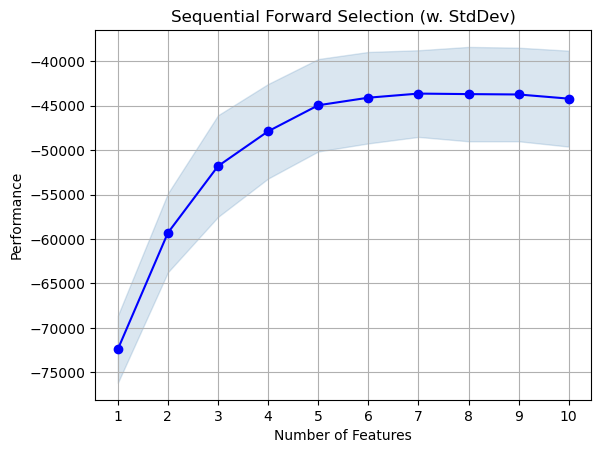

In [103]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [32]:
parameters = {
    "n_estimators": randint(200, 500), # no. trees in the forest
    "min_samples_leaf": randint(1, 30), # min no. samples at leaf node
    "max_depth" : randint(5, 50), # max depth of each tree
    # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
    "max_leaf_nodes": randint(200, 500) # size of tree, how many end nodes
}

In [33]:
retain = ["demand"] + selected_features

In [34]:
final_features = region_dfs[region][retain]

In [35]:
final_features.head()

,demand,t2min,q,msdwswrf,t2m,mtpr,t2max,cdd
2006-01-09,1.705217e+06,272.657808,4.025527,47.682237,275.296031,2.371277e-05,279.068155,-0.010986
2006-01-10,1.758981e+06,271.595228,3.784367,48.892031,274.142046,8.657164e-07,277.980809,-0.010988
2006-01-11,1.767110e+06,272.089441,3.937797,43.395979,274.746300,1.894812e-05,278.607238,-0.010990
2006-01-12,1.730977e+06,273.560888,4.345852,36.045634,276.125578,4.888885e-06,278.765070,-0.010992
2006-01-13,1.702120e+06,272.924578,3.917686,58.909644,275.437413,1.039919e-06,279.551716,-0.010994


In [36]:
train_X, test_X, train_y, test_y = fn.split(
    fn.sel_train_test(final_features, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [37]:
# # very restricted space for testing
# parameters = {
#     "n_estimators": randint(10, 12), # no. trees in the forest
# }

In [38]:
rf = ExtraTreesRegressor()

In [39]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2006 2006 2006 ... 2015 2015 2015]


In [40]:
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=200
)

In [41]:
best_params

{'max_depth': 38,
 'max_leaf_nodes': 367,
 'min_samples_leaf': 1,
 'n_estimators': 489}

## Finalise model

In [42]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [43]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [44]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [45]:
pred_train.shape

(2267,)

In [46]:
pred_test.shape

(677,)

## Evaluate performance

In [47]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error,
           mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [48]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [121]:
train_scores

[0.9552510375939364,
 36431.08988068906,
 2634074896.539016,
 0.027041094806112873,
 26722.778213988757]

In [49]:
train_scores

[0.9852297740989927,
 21734.802618407826,
 869425326.7597971,
 0.016595996360607514,
 17190.118735994678]

In [50]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [123]:
test_scores

[0.9472517899998211,
 40661.91889544719,
 3339329426.1477222,
 0.02941762168632571,
 27637.343076422112]

In [51]:
test_scores

[0.9480116395412623,
 39970.5157208191,
 3291225652.8979535,
 0.02882122958306124,
 26685.2825520779]

In [52]:
def plot_scores(train, test, metric_names):
    """
    Subplot for each metric showing score for train and test.
    """
    fig, ax = plt.subplots(2, 3, figsize=(10, 6))
    for i, a in enumerate(ax.flatten()):
        if i < len(metric_names):
            a.bar(["Train", "Test"], [train[i], test[i]])
            a.set_title(metric_names[i])
    plt.tight_layout()

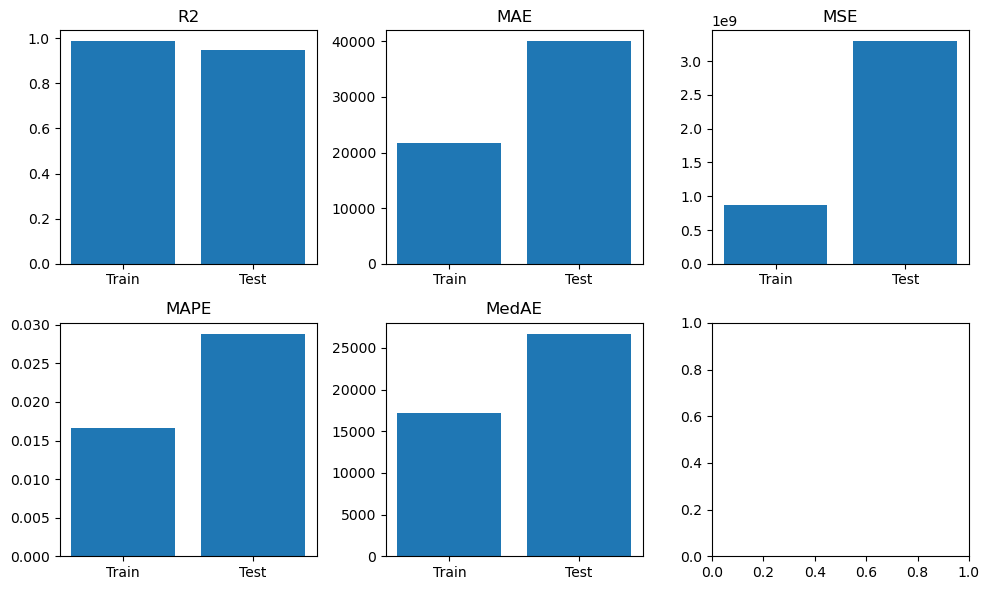

In [53]:
plot_scores(train_scores, test_scores, metric_names)

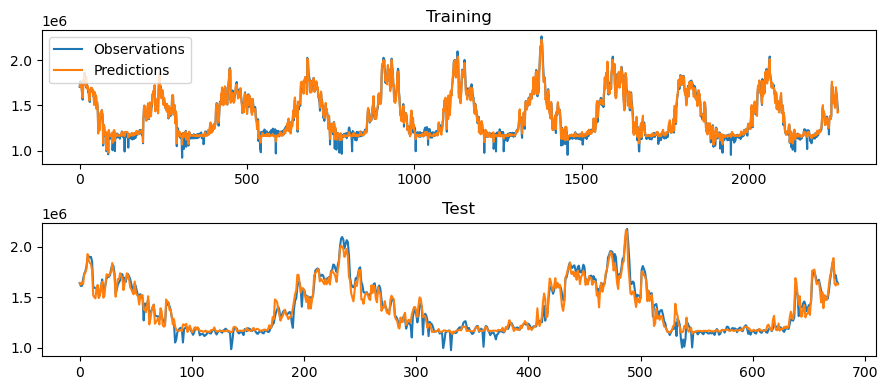

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

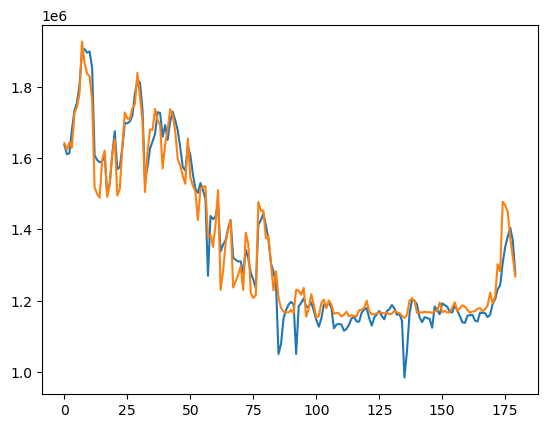

In [55]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

## Performance by day of the week

In [56]:
error_df = pd.DataFrame(
    test_y,
    index = final_features[
        (final_features.index.year >= first_test_year) &
        (final_features.index.year <= last_test_year)
    ].index,
    columns=["demand"]
)

In [57]:
error_df["prediction"] = pred_test

In [58]:
error_df["error"] = test_y - pred_test

In [59]:
error_df["abs_error"] = np.abs(test_y - pred_test)

In [60]:
error_df["sq_error"] = (test_y - pred_test) ** 2

In [61]:
error_df["abs_error"].groupby(error_df.index.weekday).mean()

0    48552.134924
1    39316.372119
2    36070.380510
3    38428.645956
4    37333.865613
Name: abs_error, dtype: float64

In [62]:
error_df["sq_error"].groupby(error_df.index.weekday).mean()

0    4.279529e+09
1    3.286564e+09
2    2.689678e+09
3    3.351016e+09
4    2.830278e+09
Name: sq_error, dtype: float64

## Permutation importances

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [112]:
perm_train = fn.perm_imp(
    model_train,
    train_X,
    train_y,
    n_repeats=2,
)

In [113]:
perm_test = fn.perm_imp(
    model_test,
    test_X,
    test_y,
    n_repeats=2,
)

In [114]:
perm_train

{'importances_mean': array([0.177155  , 0.05666925, 0.00144561, 0.00985985, 0.53398609,
        0.17049582, 0.00094452]),
 'importances_std': array([5.15550787e-04, 1.07742284e-04, 6.34458874e-06, 4.93632263e-04,
        5.60215008e-04, 5.46410985e-06, 2.52766840e-05]),
 'importances': array([[0.17663945, 0.17767055],
        [0.056777  , 0.05656151],
        [0.00143926, 0.00145195],
        [0.00936622, 0.01035349],
        [0.5345463 , 0.53342587],
        [0.17049036, 0.17050129],
        [0.00091924, 0.0009698 ]])}

In [115]:
perm_test

{'importances_mean': array([1.53757324e-01, 5.89022394e-02, 7.14255622e-04, 6.54215064e-03,
        5.38360922e-01, 1.65642262e-01, 3.56746693e-04]),
 'importances_std': array([4.52798394e-03, 1.14930909e-03, 8.76817433e-06, 1.05591314e-04,
        1.40634946e-02, 4.37519790e-03, 4.01823902e-06]),
 'importances': array([[1.49229340e-01, 1.58285308e-01],
        [5.77529303e-02, 6.00515485e-02],
        [7.23023796e-04, 7.05487448e-04],
        [6.64774196e-03, 6.43655933e-03],
        [5.52424416e-01, 5.24297427e-01],
        [1.70017460e-01, 1.61267064e-01],
        [3.60764932e-04, 3.52728454e-04]])}

In [116]:
fn.print_perm_imp(perm_train, selected_features)

hdd      0.534 +/- 0.001
is_weekend 0.177 +/- 0.001
t2min    0.170 +/- 0.000
msdwswrf 0.057 +/- 0.000
cdd      0.010 +/- 0.000
w10      0.001 +/- 0.000
mtpr     0.001 +/- 0.000


In [117]:
fn.print_perm_imp(perm_test, selected_features)

hdd      0.538 +/- 0.014
t2min    0.166 +/- 0.004
is_weekend 0.154 +/- 0.005
msdwswrf 0.059 +/- 0.001
cdd      0.007 +/- 0.000
w10      0.001 +/- 0.000
mtpr     0.000 +/- 0.000
